### The next step in the gap analysis is to calculate the Turbine Ideal Energy (TIE) for the wind farm based on SCADA data

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook provides an overview and walk-through of the turbine ideal energy (TIE) method in OpenOA. The TIE metric is defined as the amount of electricity generated by all turbines at a wind farm operating under normal conditions (i.e., not subject to downtime or significant underperformance, but subject to wake losses and moderate turbine performance losses). The approach to calculate TIE is to :

1. Filter out underperforming data from the power curve for each turbine, 
2. Develop a statistical relationship between the remaining power data and key atmospheric variables from a long-term    reanalysis product
3. Long-term correct the period of record power data using the above statistical relationship
4. Sum up the long-term corrected power data across all turbines to get TIE for the wind farm

Here we use different reanalysis products to capture the uncertainty around the modeled wind resource. We also consider uncertainty due to power data accuracy and the filtering choices made by the analyst.

In [7]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from project_ENGIE import Project_Engie
from operational_analysis.methods import turbine_long_term_gross_energy

/Users/moptis/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/data/la_haute_borne' folder

In [8]:
# Load plant object
project = Project_Engie('./data/la_haute_borne/')

In [9]:
# Load and prepare the wind farm data
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:operational_analysis.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:operational_analysis.types.timeseries_table:Loading name:era5_wind_la_haute_borne


In [10]:
# Let's take a look at the columns in the SCADA data frame
project._scada.df.columns

Index(['id', 'wrot_BlPthAngVal1_avg', 'wmet_wdspd_avg', 'wmet_VaneDir_avg',
       'wmet_EnvTmp_avg', 'wyaw_YwAng_avg', 'wmet_HorWdDir_avg', 'wtur_W_avg',
       'energy_kwh'],
      dtype='object')

Next we create a TIE object which will contain the analysis to be performed. The method has the ability to calculate uncertainty in the TIE metric through a Monte Carlo sampling of filtering thresholds, power data, and reanalysis product choices. For now, we turn this option off run the method a single time.

In [22]:
# Note the UQ = False parameters to not enable Monte Carlo
ta = turbine_long_term_gross_energy.TurbineLongTermGrossEnergy(project, UQ = False) 

INFO:operational_analysis.methods.turbine_long_term_gross_energy:Initializing TurbineLongTermGrossEnergy Object
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Note: uncertainty quantification will NOT be performed in the calculation
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing SCADA data into dictionaries by turbine (this can take a while)


All of the steps in the TI calculation process are pulled under a single run() function. These steps include:
1. Processing reanalysis data to daily averages.
2. Filtering the SCADA data
3. Fitting the daily reanalysis data to daily SCADA data using a Generalized Additive Model (GAM)
4. Apply GAM results to calculate long-term TIE for the wind farm

By setting UQ = False, we must manually specify key filtering thresholds that would otherwise be sampled from a range of values through Monte Carlo. Specifically, we must set thresholds applied to the bin_filter() function in the toolkits.filtering class of OpenOA. 

In [24]:
# Specify filter threshold values to be used
wind_bin_thresh = 2.0 # Exclude data outside 2 m/s of the median for each power bin
max_power_filter = 0.90 # Don't apply bin filter above 0.9 of turbine capacity

We also must decide how to deal with missing data when computing daily sums of energy production from each turbine. Here we set the threshold at 0.9 (i.e., if greater than 90% of SCADA data is available for a given day, scale up the daily energy by the fraction of data misisng. If less than 90% data recovery, exclude that day from analysis

In [25]:
# Set the correction threshold to 90%
correction_threshold = 0.90

In [26]:
# Here we choose two reanalysis products to be used in the TIE calculation process.
# We can choose to save key plots to a file by setting enable_plotting = True and 
#specifying a directory to save the images. For now we turn off this feature. 
ta.run(reanal_subset = ['era5', 'merra2'], enable_plotting = False, plot_dir = None,
       wind_bin_thresh = wind_bin_thresh, max_power_filter = max_power_filter,
       correction_threshold = correction_threshold)


  0%|          | 0/2 [00:00<?, ?it/s]INFO:operational_analysis.methods.turbine_long_term_gross_energy:Filtering turbine data
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing reanalysis data to daily averages
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing scada data to daily sums


0it [00:00, ?it/s]

4it [00:00, 23.83it/s]
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Setting up daily data for model fitting
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Fitting model data
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Applying fitting results to calculate long-term gross energy

 50%|█████     | 1/2 [00:01<00:01,  1.88s/it]INFO:operational_analysis.methods.turbine_long_term_gross_energy:Filtering turbine data
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing reanalysis data to daily averages
INFO:operational_analysis.methods.turbine_long_term_gross_e

Now that we've finished the TIE calculation, let's examine results

In [27]:
# What is the long-term annual TIE for whole plant
print('Long-term turbine ideal energy is %s GWh/year' %np.round(np.mean(ta._plant_gross/1e6),1))

Long-term turbine ideal energy is 13.7 GWh/year


We can examine how well the filtering worked by examining the power curves for each turbine using the plot_filtered_power_curves() function.

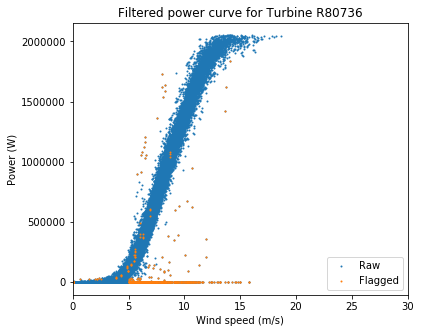

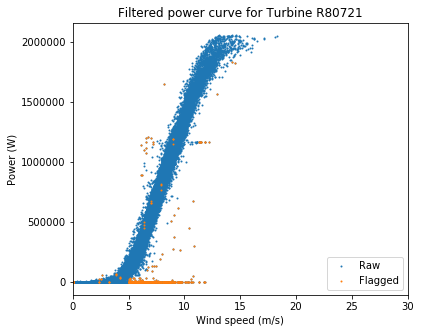

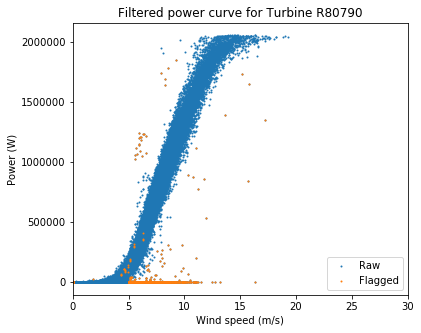

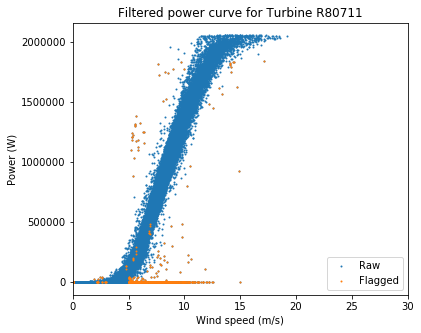

In [29]:
# Make sure the output directory exists!
ta.plot_filtered_power_curves(save_folder = "/Users/moptis/Documents/temp/", output_to_terminal = True)

Overall these are very clean power curves, and the filtering algorithms seem to have done a good job of catching the most egregious outliers.

Now let's look at the daily data and how well the power curve fit worked

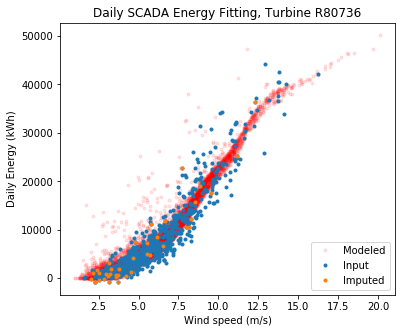

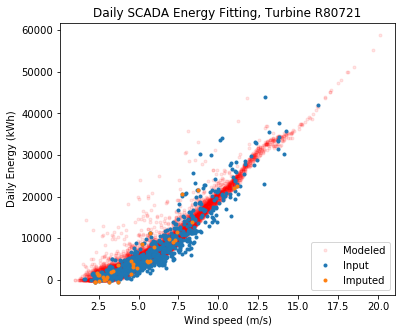

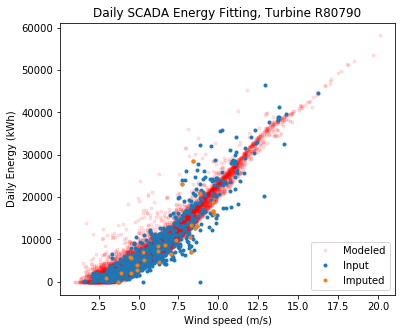

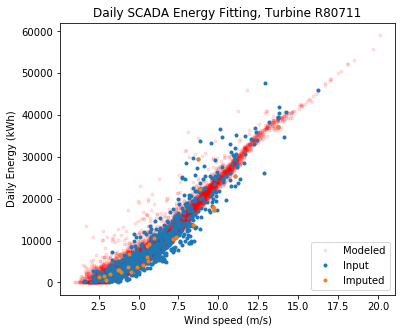

In [30]:
ta.plot_daily_fitting_result(save_folder = "/Users/moptis/Documents/temp/", output_to_terminal = True)

Overall the fit looks good. The modeled data sometimes estimate higher energy at low wind speeds compared to the observed, but keep in mind the model fits to long term wind speed, wind direction, and air density, whereas we are only showing the relationship to wind speed here.

Note that 'imputed' means daily power data that was missing for a specific turbine, but was calculated by establishing statistical relationships with that turbine and its neighbors. This is necessary since a wind farm often has one turbine down and, without imputation, very little daily data would be left if we excluded days when a turbine was down.